In [48]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

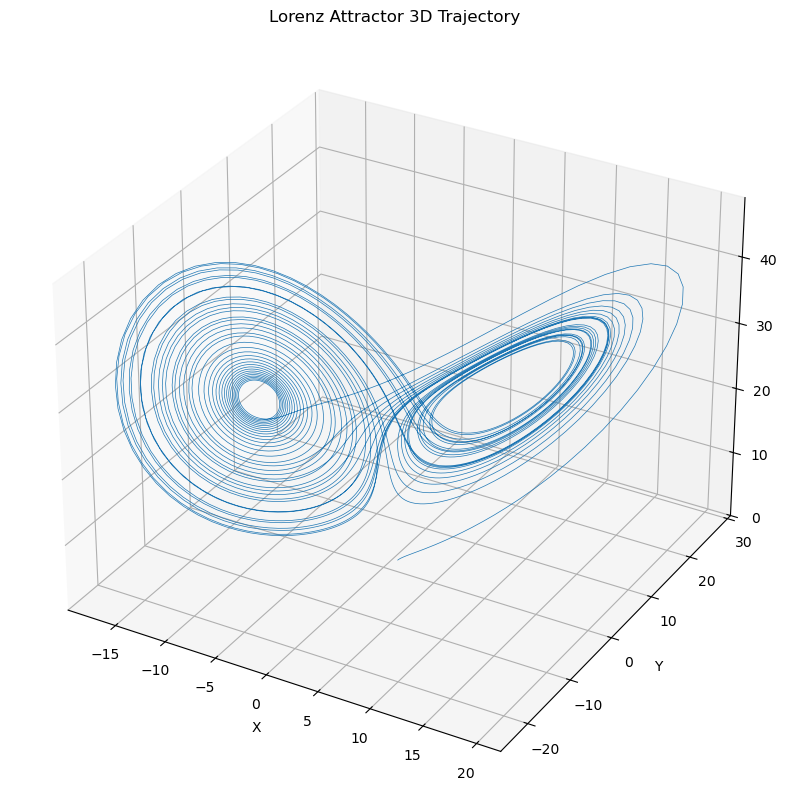

Text(0, 0.5, 'X')

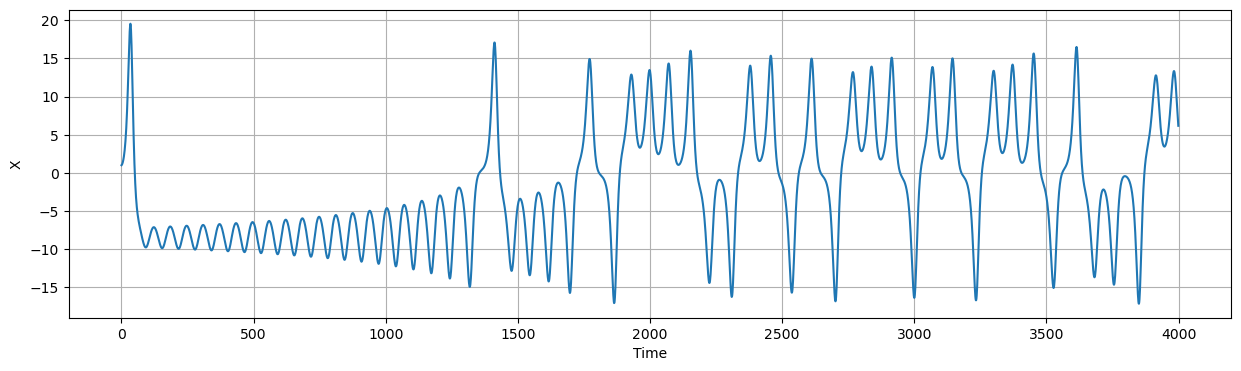

In [95]:
# 1) Build a short Lorenz x‐series (NumPy + RK4)
def lorenz_step(s, dt=0.01, σ=10., ρ=28., β=8/3):
    x, y, z = s
    def f(u):
        x, y, z = u
        return np.array([σ*(y-x), x*(ρ-z)-y, x*y - β*z], dtype=np.float32)
    k1 = f(s)
    k2 = f(s + dt*k1/2)
    k3 = f(s + dt*k2/2)
    k4 = f(s + dt*k3)
    return s + dt*(k1 + 2*k2 + 2*k3 + k4)/6

state = np.array([1.,1.,1.], dtype=np.float32)
xs = []
states = []
for _ in range(4000):  # shorter series for clarity
    states.append(state)
    state = lorenz_step(state)
    xs.append(state[0])
states = np.array(states, dtype=np.float32)
xs = np.array(xs, dtype=np.float32)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(states[:, 0], states[:, 1], states[:, 2], lw=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Lorenz Attractor 3D Trajectory")
plt.show()

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xs)
ax.grid(True)
ax.set_xlabel("Time")
ax.set_ylabel("X")

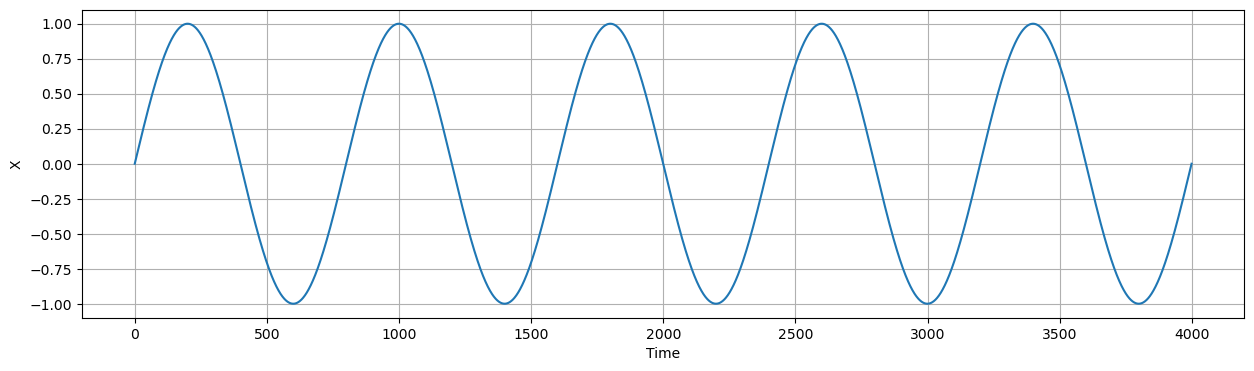

In [50]:
# alternate timeseries

xs = np.sin(np.linspace(0, 10*np.pi, 4000))
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xs)
ax.grid(True)
ax.set_xlabel("Time")
ax.set_ylabel("X")
plt.show()

In [180]:
# ─── Hyperparameters ────────────────────────────────────────────────────────
seq_len     = 100       # how many past steps to read
pred_len    = 50       # how many future steps to predict
hidden_size = 256      # dimension of the RNN hidden state
lr          = 5e-3     # learning rate
ntrain      = 32      # number of training iterations
npairs      = 1000      # number of training pairs

In [181]:
# 2) Window into one (history → future) pair
#    (in real training you'd build many; here we pick the very first)
x_hist = xs[0:seq_len]                     # shape (seq_len,)
y_true = xs[seq_len : seq_len+pred_len]    # shape (pred_len,)

# convert to JAX arrays
x_hist = jnp.array(x_hist)
y_true = jnp.array(y_true)

In [182]:
# 3) Initialize RNN parameters by hand
key = jax.random.PRNGKey(0)
key, sub = jax.random.split(key)
Wxh = jax.random.normal(sub, (hidden_size,)) * 0.1   # input→hidden (scalar input)
key, sub = jax.random.split(key)
Whh = jax.random.normal(sub, (hidden_size, hidden_size)) * 0.1
bh  = jnp.zeros((hidden_size,))                       # hidden bias
key, sub = jax.random.split(key)
Why = jax.random.normal(sub, (pred_len, hidden_size)) * 0.1  # hidden→output
by  = jnp.zeros((pred_len,))                          # output bias

params = {'Wxh': Wxh, 'Whh': Whh, 'bh': bh, 'Why': Why, 'by': by}
for k, v in params.items():
    print(f"{k}: {v.shape}")


Wxh: (256,)
Whh: (256, 256)
bh: (256,)
Why: (50, 256)
by: (50,)


In [183]:
# 4) A plain‐Python RNN forward pass
@jax.jit
def rnn_forward(p, x_seq):
    h = jnp.zeros((hidden_size,))
    for t in range(seq_len):
        x_t = x_seq[t]                     # scalar
        # elementwise Wxh * x_t + matrix Whh @ h + bias
        h = jnp.tanh(p['Wxh'] * x_t + p['Whh'] @ h + p['bh'])
    # final linear read‐out
    return p['Why'] @ h + p['by']         # shape (pred_len,)

In [184]:
# 5) MSE loss and its gradient
@jax.jit
def loss_fn(p, x_seq, y_true):
    y_pred = rnn_forward(p, x_seq)
    return jnp.mean((y_pred - y_true)**2)

grad_fn = jax.jit(jax.grad(loss_fn))

In [185]:
# 6) Compute gradient on our single example, do one SGD step
# print('Loss[{}] = {}'.format(0, loss_fn(params, x_hist, y_true)))


ioffsets = []
losses = []
for n in range(npairs):  # train for 100 pairs

    # select a random history→future pair
    ioffset = np.random.randint(0, len(xs) - seq_len - pred_len)
    ioffsets.append(ioffset)
    x_hist = jnp.array(xs[ioffset:ioffset+seq_len])
    y_true = jnp.array(xs[ioffset+seq_len:ioffset+seq_len+pred_len])

    # compute the loss and its gradient, update the parameters
    for _ in range(ntrain):
        grads = grad_fn(params, x_hist, y_true)
        params = {k: params[k] - lr * grads[k] for k in params}

    losses.append(loss_fn(params, x_hist, y_true))
    print('Loss[{}] = {}'.format(n, loss_fn(params, x_hist, y_true)))


Loss[0] = 4.123035430908203
Loss[1] = 1.576650619506836
Loss[2] = 0.6423748731613159
Loss[3] = 0.05646463856101036
Loss[4] = 4.146296501159668
Loss[5] = 2.9133121967315674
Loss[6] = 2.3729159832000732
Loss[7] = 0.5191482305526733
Loss[8] = 0.3158004581928253
Loss[9] = 0.24835078418254852
Loss[10] = 1.1435328722000122
Loss[11] = 1.5441733598709106
Loss[12] = 0.2043209820985794
Loss[13] = 1.139305830001831
Loss[14] = 0.5701027512550354
Loss[15] = 0.49716806411743164
Loss[16] = 0.5115719437599182
Loss[17] = 1.713243007659912
Loss[18] = 0.01765996590256691
Loss[19] = 0.15702344477176666
Loss[20] = 0.7275031805038452
Loss[21] = 0.019487738609313965
Loss[22] = 1.143660545349121
Loss[23] = 0.7119413018226624
Loss[24] = 1.3391849994659424
Loss[25] = 0.5374079942703247
Loss[26] = 1.353294014930725
Loss[27] = 1.3507171869277954
Loss[28] = 2.4781885147094727
Loss[29] = 1.8706856966018677
Loss[30] = 0.18721629679203033
Loss[31] = 0.9017065167427063
Loss[32] = 0.07134827226400375
Loss[33] = 0.02574

/var/folders/m6/rd61rwbn1yq0ft30675v8xlh0000gn/T/ipykernel_49708/1121628110.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


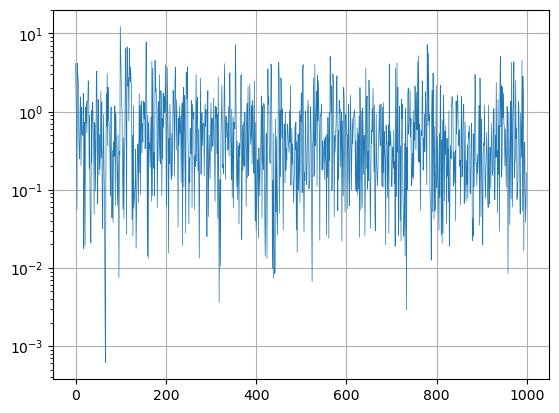

In [186]:
fig, ax = plt.subplots()
ax.semilogy(losses, lw=0.5)
ax.grid(True)
fig.show()

/var/folders/m6/rd61rwbn1yq0ft30675v8xlh0000gn/T/ipykernel_49708/651507020.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


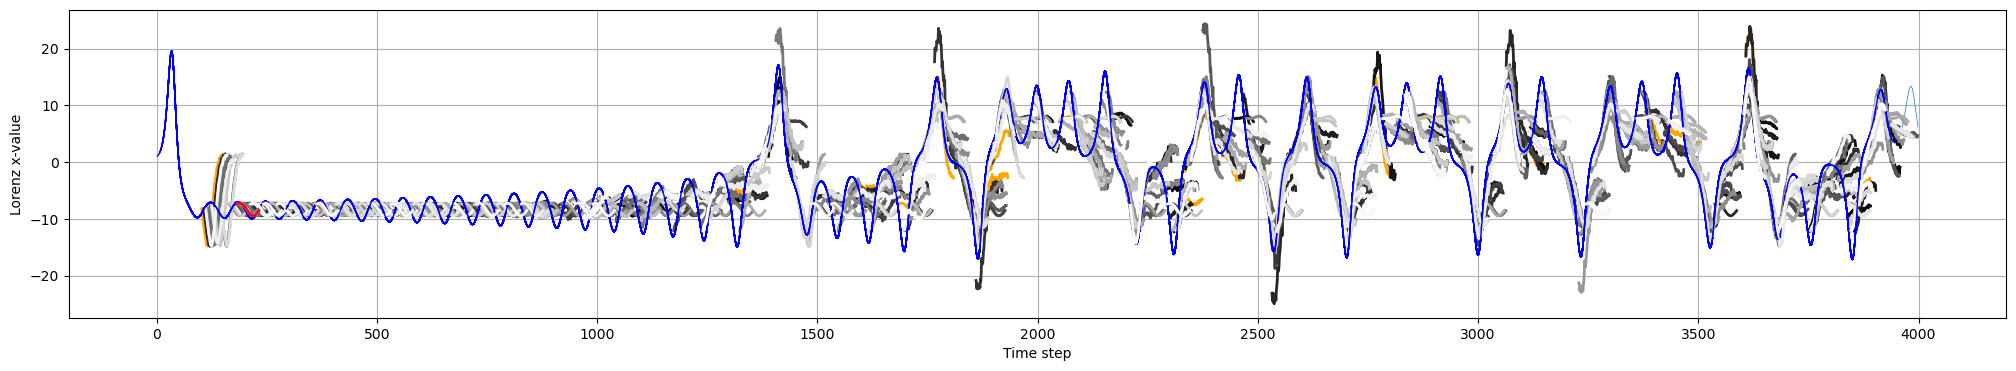

In [187]:

fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(xs, lw=0.5)

for n in range(50):
    # select a random history→future pair
    ioffset = np.random.randint(0, len(xs) - seq_len - pred_len)
    x_hist = jnp.array(xs[ioffset:ioffset+seq_len])
    y_pred = np.array(rnn_forward(params, x_hist))
    ax.plot(np.arange(ioffset, seq_len+ioffset), x_hist,  lw=1, color='blue')
    ax.plot(np.arange(seq_len+ioffset, seq_len+pred_len+ioffset), y_pred,  lw=2, color='orange')

for n, ioffset in enumerate(ioffsets):
    x_hist = jnp.array(xs[ioffset:ioffset+seq_len])
    y_pred = np.array(rnn_forward(params, x_hist))
    ax.plot(np.arange(ioffset, seq_len+ioffset), x_hist,  lw=1, color='blue')
    color = n/len(ioffsets)
    ax.plot(np.arange(seq_len+ioffset, seq_len+pred_len+ioffset), y_pred,  lw=2, color=str(color))

ax.plot(np.arange(seq_len+ioffset, seq_len+pred_len+ioffset), y_pred,  lw=2, color='red')

ax.grid(True)
ax.set_xlabel("Time step")
ax.set_ylabel("Lorenz x-value")
fig.show()    
